# Research Example: Stellar Variability Analysis with TESS

This notebook demonstrates how to:
1. Load and analyze TESS light curves
2. Find periods using Lomb-Scargle periodograms
3. Classify variable star types
4. Visualize period-amplitude relationships

## Research Applications
- Discovering new variable stars
- Calibrating period-luminosity relations
- Studying stellar pulsation physics
- Finding exoplanet transits

## 1. Setup and Imports

First, we'll import all the necessary packages for time series analysis and visualization.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset
from astropy.timeseries import LombScargle
import warnings
warnings.filterwarnings('ignore')

print("✅ All packages imported successfully")

✅ All packages imported successfully


## 2. Research Motivation

### Why Study Variable Stars?

Variable stars are crucial for astronomy because they:
1. **Serve as standard candles** for distance measurements (Cepheids, RR Lyrae)
2. **Probe stellar interiors** through asteroseismology
3. **Trace stellar evolution** endpoints (pulsating white dwarfs)
4. **Help discover exoplanets** through transits

### TESS (Transiting Exoplanet Survey Satellite)

TESS provides:
- 2-minute to 30-minute cadence observations
- ~27-day continuous coverage per sector
- All-sky coverage over 2+ years
- Precision photometry for millions of stars

### Our Research Goals
- Identify periodic variables in TESS data
- Classify them based on period and amplitude
- Create period-amplitude diagrams

## 3. Load TESS Light Curves

We'll load TESS light curves from the Multimodal Universe dataset using streaming mode.

In [2]:
# Load TESS data
print("Loading TESS dataset...")
tess_data = load_dataset(
    "MultimodalUniverse/tess",
    split="train",
    streaming=True
)

print("✅ TESS dataset loaded in streaming mode")

Loading TESS dataset...


✅ TESS dataset loaded in streaming mode


### Collect Light Curves for Analysis

We'll collect 20 targets to analyze. For a real research project, you would analyze many more!

In [3]:
light_curves = []
tess_iter = iter(tess_data)
n_targets = 20  # Number of targets to analyze

for i in range(n_targets):
    try:
        tess_obj = next(tess_iter)

        # Extract light curve
        lc = tess_obj['lightcurve']
        times = np.array(lc['time'])
        flux = np.array(lc['flux'])
        flux_err = np.array(lc.get('flux_err', np.ones_like(flux) * 0.001))

        # Clean data (remove NaN)
        mask = ~np.isnan(flux) & ~np.isnan(times) & (flux > 0)
        if np.sum(mask) < 100:  # Need enough points
            continue

        times = times[mask]
        flux = flux[mask]
        flux_err = flux_err[mask]

        # Normalize flux
        median_flux = np.median(flux)
        norm_flux = flux / median_flux - 1  # Convert to fractional variation
        norm_flux_err = flux_err / median_flux

        light_curves.append({
            'object_id': tess_obj['object_id'],
            'ra': tess_obj['RA'],
            'dec': tess_obj['DEC'],
            'times': times,
            'flux': norm_flux,
            'flux_err': norm_flux_err,
            'n_points': len(times)
        })

        print(f"  Loaded {i+1}/{n_targets}: {tess_obj['object_id']}")

    except Exception as e:
        print(f"  Skipped object {i+1}: {str(e)}")
        continue

print(f"\n✅ Loaded {len(light_curves)} light curves for analysis")

  Loaded 1/20: 229761376
  Loaded 2/20: 229761447
  Loaded 3/20: 229761513
  Loaded 4/20: 229766703
  Loaded 5/20: 229766711
  Loaded 6/20: 229766793
  Loaded 7/20: 229766854
  Loaded 8/20: 229772391
  Loaded 9/20: 229910008
  Loaded 10/20: 229910017
  Loaded 11/20: 229910117
  Loaded 12/20: 229910145
  Loaded 13/20: 229910234
  Loaded 14/20: 229910436
  Loaded 15/20: 229910483
  Loaded 16/20: 229910614
  Loaded 17/20: 229910635
  Loaded 18/20: 229910644
  Loaded 19/20: 229910721
  Loaded 20/20: 229910746

✅ Loaded 20 light curves for analysis


## 4. Period Finding with Lomb-Scargle

The Lomb-Scargle periodogram is a common method for finding periods in unevenly sampled time series data in astronomy.

In [4]:
def find_period(times, flux, flux_err, min_period=0.1, max_period=15.0):
    """
    Find the dominant period in a light curve using Lomb-Scargle.

    Parameters:
    - times: observation times (days)
    - flux: normalized flux values
    - flux_err: flux uncertainties
    - min_period, max_period: period search range (days)

    Returns:
    - best_period: most likely period (days)
    - power: periodogram power at best period
    - ls: LombScargle object for further analysis
    - fap: false alarm probability
    """

    # Create frequency grid
    min_freq = 1 / max_period
    max_freq = 1 / min_period

    # Lomb-Scargle periodogram
    ls = LombScargle(times, flux, flux_err)
    frequency, power = ls.autopower(
        minimum_frequency=min_freq,
        maximum_frequency=max_freq,
        samples_per_peak=10
    )

    # Find best period
    best_freq = frequency[np.argmax(power)]
    best_period = 1 / best_freq
    max_power = np.max(power)

    # Calculate false alarm probability
    fap = ls.false_alarm_probability(max_power)

    return best_period, max_power, ls, fap

print("✅ Period finding function defined")

✅ Period finding function defined


### Analyze Each Light Curve

We will now run our "period finding" function over the data. Note that this is definitely *not* what you would do to identify specific types of variable stars in general: stars have tons of variability, and so you'll see tons of signals in the Lomb-Scargle periodagram corresponding to all sorts of activity at a wide variety of length scales. (We'll show a plot later.)

However, it's at least a good place to start as an illustrative example!

In [ ]:
results = []
for i, lc in enumerate(light_curves):
    print(f"\nAnalyzing object {i+1}/{len(light_curves)}: {lc['object_id']}")

    try:
        # Find period
        period, power, ls, fap = find_period(
            lc['times'], lc['flux'], lc['flux_err']
        )

        # Calculate amplitude (peak-to-peak)
        amplitude = np.max(lc['flux']) - np.min(lc['flux'])

        # Store results
        results.append({
            'object_id': lc['object_id'],
            'ra': lc['ra'],
            'dec': lc['dec'],
            'period': period,
            'power': power,
            'amplitude': amplitude,
            'false_alarm_prob': fap,
            'n_points': lc['n_points']
        })

        print(f"  Period: {period:.3f} days")
        print(f"  Amplitude: {amplitude:.4f} (fractional)")
        print(f"  FAP: {fap:.2e}")

    except Exception as e:
        print(f"  Failed: {str(e)}")
        continue

# Convert to DataFrame
results_df = pd.DataFrame(results)
print(f"\n✅ Analyzed {len(results_df)} light curves successfully")


Analyzing object 1/20: 229761376
  Period: 2.773 days
  Amplitude: 0.0052 (fractional)
  FAP: 3.07e-21

Analyzing object 2/20: 229761447
  Period: 9.294 days
  Amplitude: 0.0097 (fractional)
  FAP: 3.76e-90

Analyzing object 3/20: 229761513
  Period: 10.370 days
  Amplitude: 0.0045 (fractional)
  FAP: 1.22e-24

Analyzing object 4/20: 229766703
  Period: 3.281 days
  Amplitude: 0.0154 (fractional)
  FAP: 1.99e-106

Analyzing object 5/20: 229766711
  Period: 0.145 days
  Amplitude: 0.0112 (fractional)
  FAP: 0.00e+00

Analyzing object 6/20: 229766793
  Period: 0.873 days
  Amplitude: 0.0065 (fractional)
  FAP: 1.24e-35

Analyzing object 7/20: 229766854
  Period: 0.968 days
  Amplitude: 0.0167 (fractional)
  FAP: 3.79e-14

Analyzing object 8/20: 229772391
  Period: 3.165 days
  Amplitude: 0.0077 (fractional)
  FAP: 9.89e-02

Analyzing object 9/20: 229910008
  Period: 3.052 days
  Amplitude: 0.0126 (fractional)
  FAP: 2.78e-20

Analyzing object 10/20: 229910017
  Period: 0.108 days
  Ampl

## 5. Variable Star Classification

We'll classify variables based on their period and amplitude. This is very much a simplified classification scheme - real classification uses more features like light curve shape, color, etc. Things also don't clearly divide up into concrete buckets.

In [6]:
def classify_variable(period, amplitude):
    """
    Simple classification based on period and amplitude.
    Real classification would use more features (color, light curve shape, etc.)

    Returns: variable type string
    """

    # Convert amplitude to millimagnitudes (approximate)
    amp_mmag = -2.5 * np.log10(1 - amplitude/2) * 1000 if amplitude < 2 else 1000

    if period < 0.2:  # Less than ~5 hours
        return "δ Scuti"
    elif 0.2 <= period < 1.0:
        if amp_mmag > 300:  # Large amplitude
            return "RR Lyrae"
        else:
            return "δ Scuti/SX Phe"
    elif 1.0 <= period < 2.5:
        if amp_mmag < 50:
            return "Rotational"
        else:
            return "Eclipsing Binary"
    elif 2.5 <= period < 20:
        if amp_mmag > 500:
            return "Cepheid"
        else:
            return "Eclipsing Binary"
    else:
        return "Long Period"

# Classify variables
results_df['var_type'] = results_df.apply(
    lambda row: classify_variable(row['period'], row['amplitude']),
    axis=1
)

# Show classification summary
print("\nVariable Star Classification Results:")
print("-" * 40)
var_counts = results_df['var_type'].value_counts()
for var_type, count in var_counts.items():
    print(f"{var_type:20s}: {count:3d} stars")


Variable Star Classification Results:
----------------------------------------
Eclipsing Binary    :  11 stars
Rotational          :   4 stars
δ Scuti/SX Phe      :   3 stars
δ Scuti             :   2 stars


## 6. Visualization: Period-Amplitude Diagram

The period-amplitude diagram is a classic diagnostic plot for variable stars. Different types of variables occupy different regions.

✅ Saved period-amplitude diagram


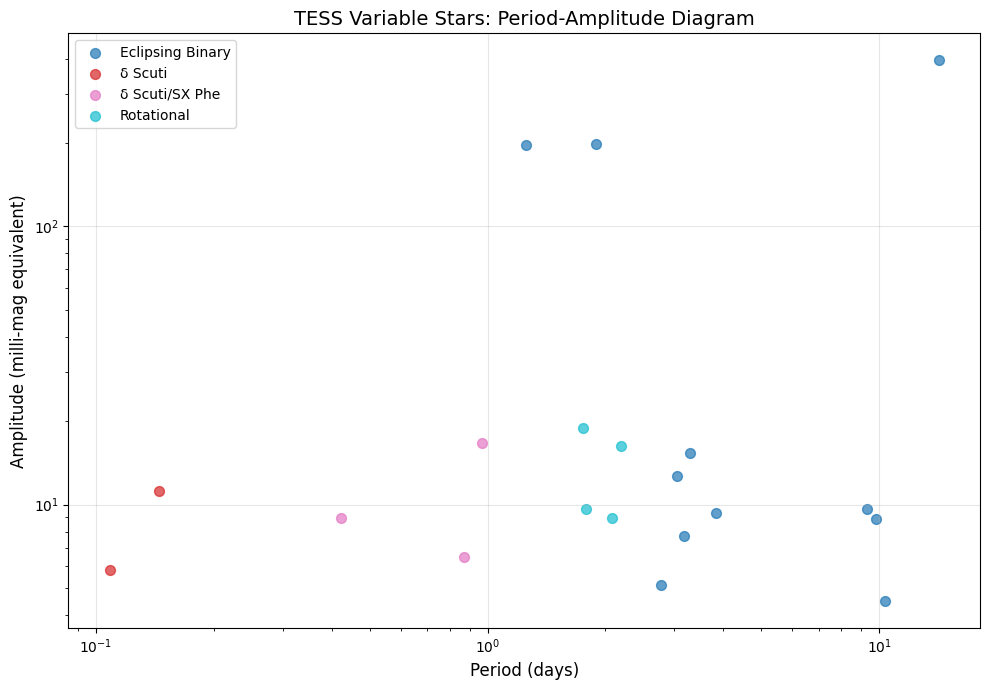

In [7]:
# Create period-amplitude diagram
fig, ax = plt.subplots(figsize=(10, 7))

# Plot by variable type
var_types = results_df['var_type'].unique()
colors = plt.cm.tab10(np.linspace(0, 1, len(var_types)))

for var_type, color in zip(var_types, colors):
    mask = results_df['var_type'] == var_type
    ax.scatter(
        results_df[mask]['period'],
        results_df[mask]['amplitude'] * 1000,  # Convert to milli-mags approx
        label=var_type,
        alpha=0.7,
        s=50,
        color=color
    )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Period (days)', fontsize=12)
ax.set_ylabel('Amplitude (milli-mag equivalent)', fontsize=12)
ax.set_title('TESS Variable Stars: Period-Amplitude Diagram', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend(loc='best')

plt.tight_layout()
plt.savefig('tess_period_amplitude.png', dpi=150, bbox_inches='tight')
print("✅ Saved period-amplitude diagram")
plt.show()

## 7. Detailed Analysis of Best Variable

Let's examine the highest-confidence variable in detail with multiple diagnostic plots.

In [8]:
# Select highest confidence variable (lowest FAP)
best_idx = results_df['false_alarm_prob'].idxmin()
best_var = results_df.iloc[best_idx]
best_lc = light_curves[best_idx]

print(f"Best variable candidate: {best_var['object_id']}")
print(f"  Period: {best_var['period']:.4f} days")
print(f"  Type: {best_var['var_type']}")
print(f"  FAP: {best_var['false_alarm_prob']:.2e}")

Best variable candidate: 229766711
  Period: 0.1446 days
  Type: δ Scuti
  FAP: 0.00e+00


✅ Saved detailed analysis


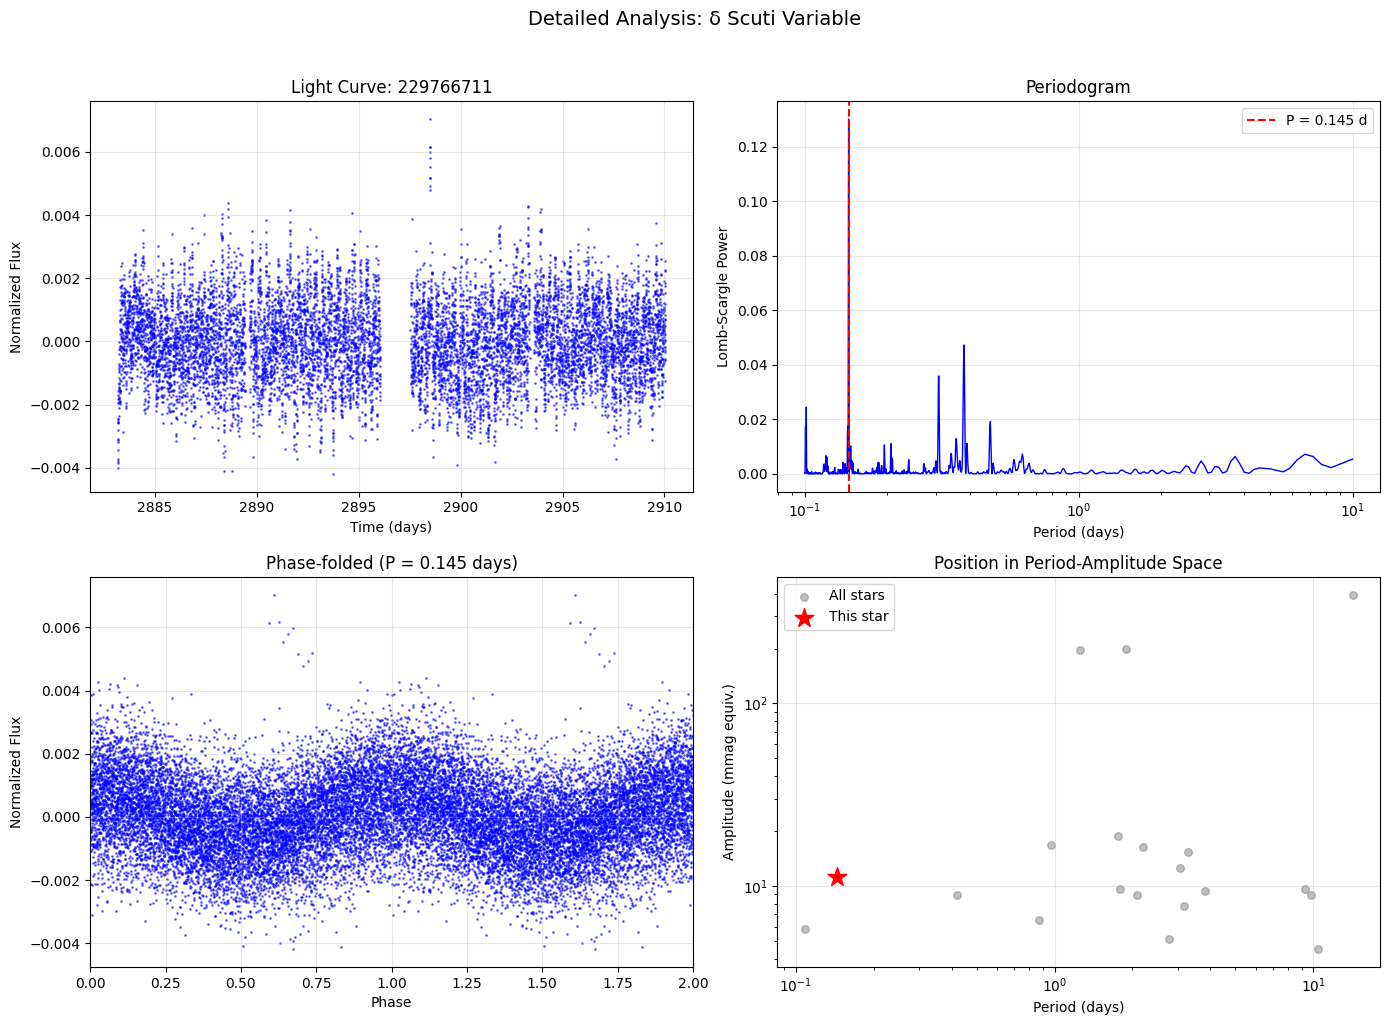

In [ ]:
# Create detailed plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Raw light curve
ax = axes[0, 0]
ax.scatter(best_lc['times'], best_lc['flux'], s=1, alpha=0.5, c='blue')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Normalized Flux')
ax.set_title(f"Light Curve: {best_var['object_id']}")
ax.grid(True, alpha=0.3)

# Plot 2: Lomb-Scargle periodogram
ax = axes[0, 1]
period, power, ls, _ = find_period(
    best_lc['times'], best_lc['flux'], best_lc['flux_err']
)
frequencies = np.linspace(0.1, 10, 1000)
powers = ls.power(frequencies)
ax.plot(1/frequencies, powers, 'b-', linewidth=1)
ax.axvline(best_var['period'], color='red', linestyle='--',
          label=f"P = {best_var['period']:.3f} d")
ax.set_xlabel('Period (days)')
ax.set_ylabel('Lomb-Scargle Power')
ax.set_title('Periodogram')
ax.set_xscale('log')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 3: Phase-folded light curve
ax = axes[1, 0]
phases = (best_lc['times'] % best_var['period']) / best_var['period']
sorted_idx = np.argsort(phases)
ax.scatter(phases[sorted_idx], best_lc['flux'][sorted_idx],
          s=1, alpha=0.5, c='blue')
# Plot twice for clarity
ax.scatter(phases[sorted_idx] + 1, best_lc['flux'][sorted_idx],
          s=1, alpha=0.5, c='blue')
ax.set_xlabel('Phase')
ax.set_ylabel('Normalized Flux')
ax.set_title(f"Phase-folded (P = {best_var['period']:.3f} days)")
ax.set_xlim(0, 2)
ax.grid(True, alpha=0.3)

# Plot 4: Period-amplitude context
ax = axes[1, 1]
ax.scatter(results_df['period'], results_df['amplitude'] * 1000,
          alpha=0.5, s=30, c='gray', label='All stars')
ax.scatter(best_var['period'], best_var['amplitude'] * 1000,
          s=200, c='red', marker='*', label='This star', zorder=5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Period (days)')
ax.set_ylabel('Amplitude (mmag equiv.)')
ax.set_title('Position in Period-Amplitude Space')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle(f"Detailed Analysis: {best_var['var_type']} Variable",
            fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('tess_best_variable.png', dpi=150, bbox_inches='tight')
print("✅ Saved detailed analysis")
plt.show()

## 8. Save Results

Export the variable star catalog for further analysis.

In [10]:
# Save results
results_df.to_csv('tess_variables_catalog.csv', index=False)
print("✅ Saved variable star catalog to tess_variables_catalog.csv")

# Display summary
print(f"\nSummary of Results:")
print(f"- Analyzed {len(light_curves)} TESS light curves")
print(f"- Found {len(results_df)} periodic variables")
print(f"- Period range: {results_df['period'].min():.3f} - {results_df['period'].max():.3f} days")
print(f"- Amplitude range: {results_df['amplitude'].min():.4f} - {results_df['amplitude'].max():.4f}")
print(f"- Best candidate: {best_var['object_id']} ({best_var['var_type']})")

✅ Saved variable star catalog to tess_variables_catalog.csv

Summary of Results:
- Analyzed 20 TESS light curves
- Found 20 periodic variables
- Period range: 0.108 - 14.171 days
- Amplitude range: 0.0045 - 0.3948
- Best candidate: 229766711 (δ Scuti)
